In [1]:
from ay_torch import *

No module named 'chainer' 



In [2]:
FUNC_KIND=3
def Func(x):
  #NOTE: Switch the function to be learned.
  global FUNC_KIND
  if FUNC_KIND==0:  return x
  if FUNC_KIND==1:  return (x[:,0]**2).reshape((-1,1))
  if FUNC_KIND==2:  return (3.0-x[:,0]).reshape((-1,1))
  if FUNC_KIND==3:  return (x[:,0]+3.0*np.sin(x[:,0])).reshape((-1,1))
  if FUNC_KIND==4:  return np.where(x[:,0]**2<1.0, 3.0, 0.0).reshape((-1,1))

def GenerateSample(xmin, xmax, N_sample, f, noise=1.0e-10):
  data_x= np.random.uniform(xmin,xmax,size=(N_sample,1))
  data_y= f(data_x) + np.random.normal(scale=noise,size=(N_sample,1))
  return data_x,data_y

In [3]:
xmin,xmax= -5.0, 5.0
N_sample= 200
#NOTE: Adjust the sample size and noise level.
data_x,data_y= GenerateSample(xmin, xmax, N_sample, Func, noise=0.5)

#Convert data to torch variables.
data_x= torch.autograd.Variable(torch.from_numpy(data_x).float())
data_y= torch.autograd.Variable(torch.from_numpy(data_y).float())

#NOTE: Adjust the batch and epoch sizes.
N_batch= 50

#Make torch dataset and loader.
test_ratio= 0.2
idxes= np.random.RandomState(seed=42).permutation(data_x.shape[0])
N_train= round(data_x.shape[0]*(1.-test_ratio))
dset_train= torch.utils.data.TensorDataset(data_x[idxes[:N_train]], data_y[idxes[:N_train]])
dset_test= torch.utils.data.TensorDataset(data_x[idxes[N_train:]], data_y[idxes[N_train:]])
dl_train= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)
dl_test= torch.utils.data.DataLoader(
      dataset=dset_train,
      batch_size=N_batch,
      shuffle=True,
      num_workers=2)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
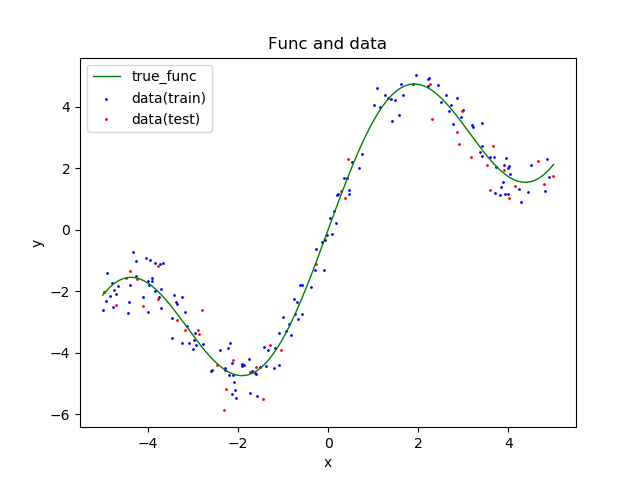

In [4]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.legend()

In [5]:
class TRegNN1(torch.nn.Module):
  def __init__(self):
    super(TRegNN1,self).__init__()
    self.lin1= torch.nn.Linear(in_features=1, out_features=1, bias=True)
  def forward(self, x):
    x= self.lin1(x)
    return x

def DefRegNN2():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(200, 100),
          torch.nn.LeakyReLU(),
          torch.nn.Linear(100, 1),
          )

def DefRegNN3():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN4():
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Linear(200, 1),
          )

def DefRegNN5(p=0.02):
  return torch.nn.Sequential(
          torch.nn.Linear(1, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 200),
          torch.nn.ReLU(),
          torch.nn.Dropout(p),
          torch.nn.Linear(200, 1),
          )

In [6]:
def _f_test(x):
  return x*x*x
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((lambda x: x*x*x,))
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + [lambda x: x*x*x]
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + (lambda x: x*x*x)
# fl= TFuncList((lambda x: x+1, lambda x: x*x)) + TFuncList((_f_test,))
fl= TFuncList((lambda x: x+1, lambda x: x*x)) + _f_test
# fl+= [_f_test]
fl+= _f_test
# fl= TFuncList()
fl(x=10)
# type(fl)
# f1

[11, 100, 1000, 1000]

In [7]:
class _TFLTest(object):
  def __init__(self):
    self.x= 100
  def FL(self):
    return TFuncList((lambda y,self=self: self.x*y,lambda y,self=self: self.x+y+11))
flt= _TFLTest()
fl= flt.FL()
flt.x= 150
fl(10)

[1500, 171]

In [8]:
# Function forward test:
def f1(x, y=None, *args, **kwargs):
  print(x,y)
def f2(*args, **kwargs):
  f1(*args, **kwargs)
f2(100,y=100)

100 100


In [9]:
d1={1:1,2:2}
d2={2:3,3:3}
d3= d2
d4={3:4,5:5}
d3= MergeDict(d1, [d3,d4])
# d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: 1, 2: 3, 3: 4, 5: 5} {2: 3, 3: 3} {1: 1, 2: 3, 3: 4, 5: 5}


In [10]:
d1={1:[1],2:[2]}
d2={2:[3],3:[3]}
d3= d2
d4={3:[4],5:[5]}
# d3= MergeDict(d1, [d3,d4])
d3= MergeDictSum(d1, [d3,d4])
print(d1,d2,d3)

{1: [1], 2: [2, 3], 3: [3, 4], 5: [5]} {2: [3], 3: [3, 4]} {1: [1], 2: [2, 3], 3: [3, 4], 5: [5]}


In [11]:
#Setup a neural network.
#net= TRegNN1()
#net= DefRegNN2()
#net= DefRegNN3()
#net= DefRegNN4()
net= DefRegNN5()

device= torch.device('cpu')
# device= torch.device('cuda')

#Setup an optimizer and a loss function.
opt= torch.optim.Adam(net.parameters(), lr=0.01)
#opt= torch.optim.SGD(net.parameters(), lr=0.004)
#opt= torch.optim.SGD(net.parameters(), lr=0.002, momentum=0.95)
#opt= torch.optim.Adadelta(net.parameters(), rho=0.9, eps=1e-8)
#opt= torch.optim.Adagrad(net.parameters())
#opt= torch.optim.RMSprop(net.parameters())
f_loss= torch.nn.MSELoss()
#f_loss= torch.nn.HuberLoss(reduction='mean', delta=0.1)

def decode(pred):
  return pred

def rmse(y,y_trg):
  return torch.sqrt(torch.nn.functional.mse_loss(y,y_trg))
f_metric= rmse

def tfm_batch(batch):
  x,y= batch
  return torch.autograd.Variable(x), torch.autograd.Variable(y)
logger= TLogger()
disp= TDisp()

In [12]:
next(net.parameters()).device==torch.device('cpu')

True

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
0	37.82587630	9.01918787	5.11114565	3.00180168	 0.239777
1	9.42922792	9.01118696	3.06587908	3.00078855	 0.128003
2	8.13834146	4.87056059	2.85117127	2.20071605	 0.106090
3	4.90349361	4.17959216	2.20885737	2.03741827	 0.127439
4	4.02415515	3.58772367	2.00204287	1.86892197	 0.115736


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
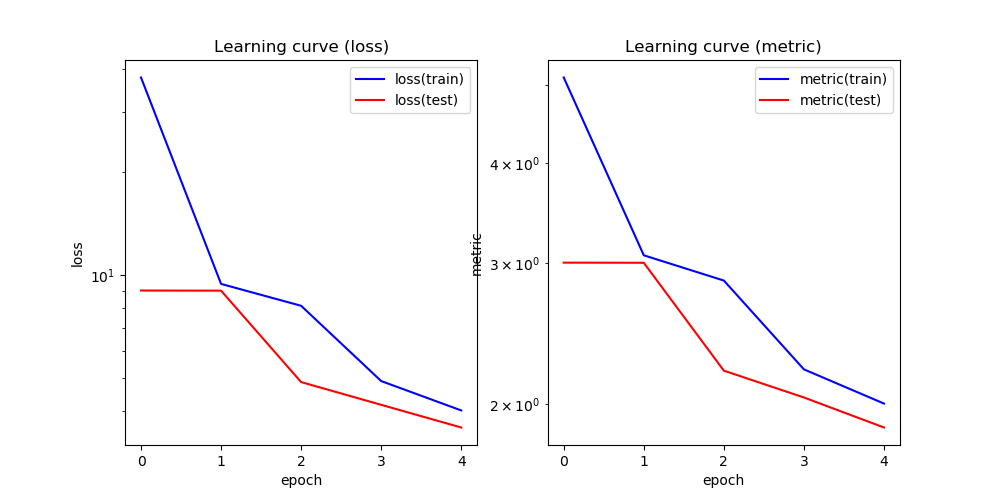

In [13]:
Fit(net, 5, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

In [14]:
len(logger.loss_test)

5

In [15]:
[pg['lr'] for pg in opt.param_groups]
[pg.keys() for pg in opt.param_groups]
# opt
opt.state_dict()
# f_loss.state_dict()
# float('inf')

{'state': {0: {'step': 20,
   'exp_avg': tensor([[-0.0374],
           [ 0.0000],
           [ 0.0154],
           [-0.0752],
           [ 0.0120],
           [ 0.0199],
           [-0.0432],
           [-0.0434],
           [-0.0866],
           [ 0.0149],
           [-0.0013],
           [ 0.0088],
           [-0.0755],
           [ 0.0200],
           [ 0.0117],
           [-0.0706],
           [-0.0850],
           [-0.0828],
           [-0.0838],
           [-0.0532],
           [-0.0939],
           [-0.0491],
           [ 0.0000],
           [ 0.0120],
           [-0.1086],
           [ 0.0133],
           [ 0.0110],
           [-0.1024],
           [ 0.0124],
           [-0.1045],
           [-0.0217],
           [ 0.0230],
           [ 0.0000],
           [-0.0929],
           [ 0.0032],
           [ 0.0000],
           [ 0.0163],
           [-0.0569],
           [-0.0568],
           [ 0.0063],
           [-0.0759],
           [ 0.0261],
           [-0.1003],
           [ 0.0

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
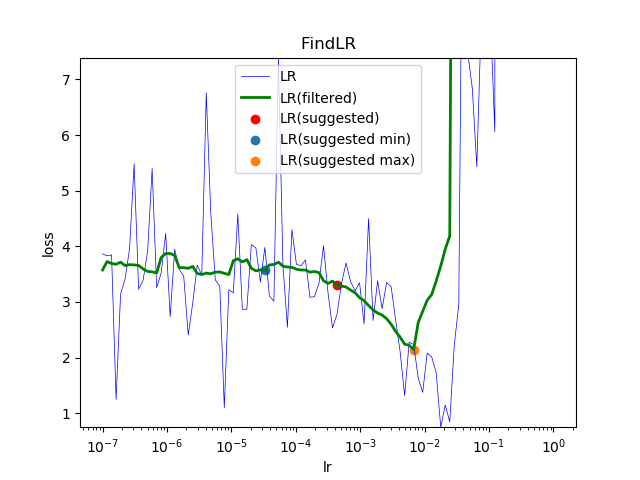

lr= 0.0004365158322401661


In [16]:
lr,_= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
5	3.66348536	3.50838023	1.91397084	1.87260643	 0.135430
6	3.49830125	3.36323933	1.85587161	1.82675898	 0.102573
7	3.36799248	3.24098605	1.82530206	1.79344248	 0.124876
8	3.17790741	3.12872350	1.78040834	1.76583639	 0.096317
9	3.14975832	3.05246314	1.77304148	1.74094020	 0.121701


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
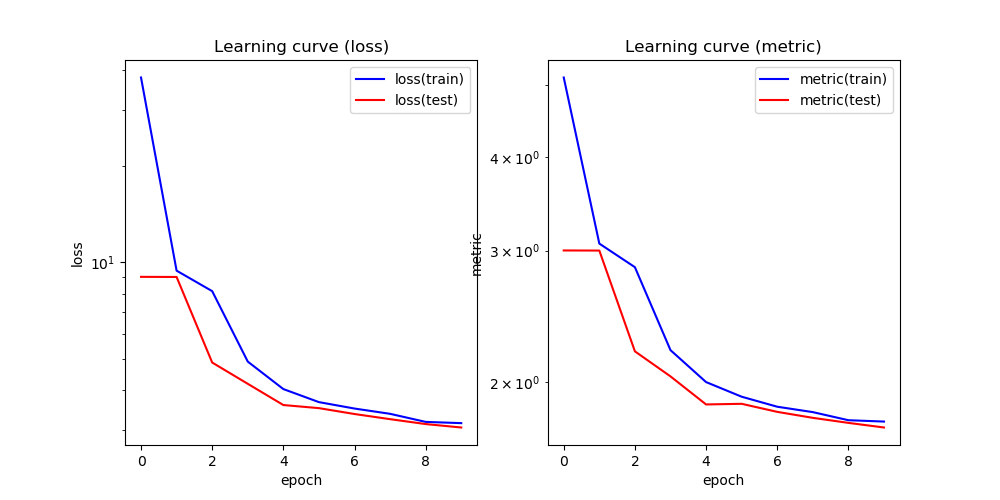

In [17]:
Fit(net, n_epoch=5, lr=lr, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
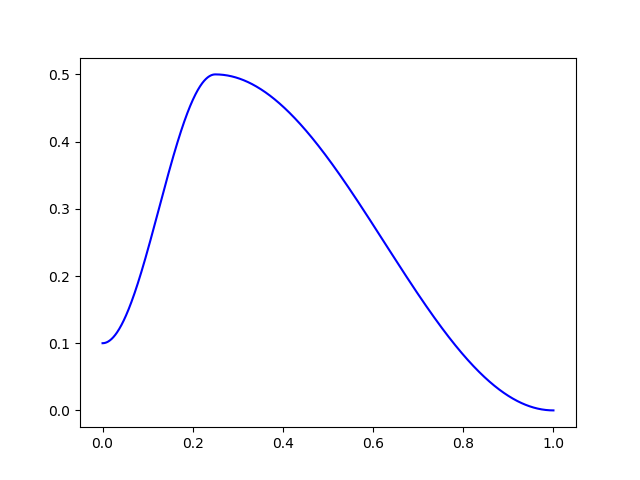

In [18]:
# via_pos= np.array([0,0.1,0.23,0.5,0.8,1.0])
# pos= np.array([0.0, 0.12, 1.2]).reshape(-1,1)
# max(0,min(len(via_pos)-2, sum(pos>=via_pos)-1))
# np.sum(pos>=via_pos,axis=1)
# cosa= lambda start,end,pos: start + (1 + np.cos(np.pi*(1-pos))) * (end-start) / 2
# sch= TScheduler('exp', 1, 0.1)
sch= TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))
fig, ax_loss= plt.subplots(1,1)
X= np.linspace(0,1,1000)
ax_loss.plot(X, [sch(x) for x in X], color='blue', label='LR')

In [19]:
TFuncList([TScheduler('exp', s, e) for s,e in zip([0.01,0.1],[1,10])])(0.2)

[0.0251188643150958, 0.251188643150958]

In [20]:
(lambda p: (TCmbScheduler(((0,0.1),(0.25,0.5),(1.0,1e-5)), ('cos','cos'))(p),
            TCmbScheduler(((0,np.array([0.1,0.01])),(0.25,np.array([0.5,0.05])),(1.0,np.array([1e-5,1e-6]))), ('cos','cos'))(p)))(0.5)

(0.37500250000000007, array([0.3750025 , 0.03750025]))

In [21]:
# learn.lr_find()
# learn.fit_one_cycle(10, 0.006); moms=(0.95,0.85,0.95)
torch.optim.SGD(torch.nn.Linear(1,1).parameters(), lr=0.002, momentum=0.95).param_groups
# torch.optim.Adam(torch.nn.Linear(1,1).parameters(), lr=0.002).param_groups

[{'params': [Parameter containing:
   tensor([[-0.9981]], requires_grad=True),
   Parameter containing:
   tensor([-0.9027], requires_grad=True)],
  'lr': 0.002,
  'momentum': 0.95,
  'dampening': 0,
  'weight_decay': 0,
  'nesterov': False}]

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
10	3.09290709	2.77703231	1.74963456	1.65153365	 0.137874
11	2.43464911	1.41597122	1.55401526	1.18329665	 0.140918
12	19.72943223	9.71447331	3.90013023	3.10559811	 0.093147
13	7.04660818	3.28718434	2.60726019	1.80176158	 0.114740
14	3.42332453	3.41523170	1.83312687	1.84438368	 0.101512
15	3.65946856	2.62935516	1.90698471	1.61038025	 0.127132
16	2.22413928	2.41762322	1.48161837	1.55257059	 0.144619
17	2.43867332	1.74702411	1.53268706	1.32087436	 0.115752
18	1.94843804	1.85993799	1.39369193	1.35974127	 0.087314
19	2.07895578	1.85017659	1.43795446	1.35635909	 0.120028


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
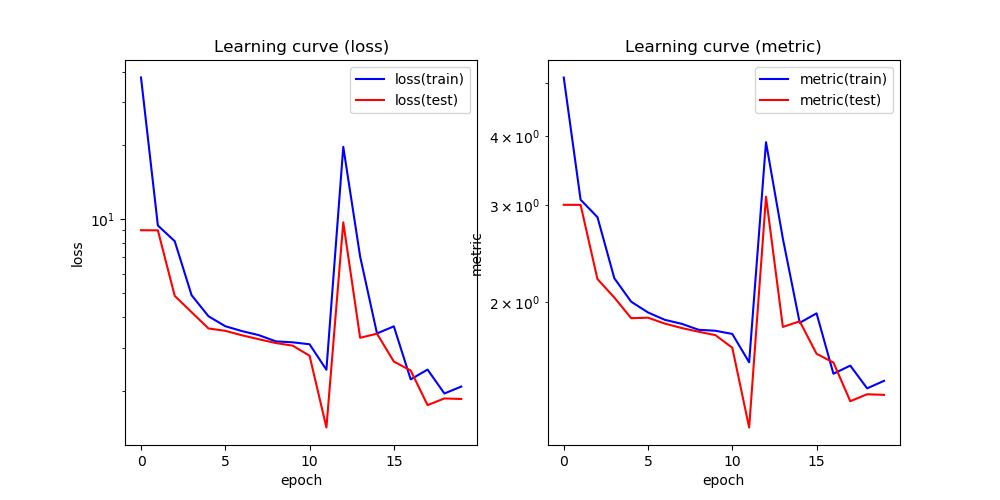

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
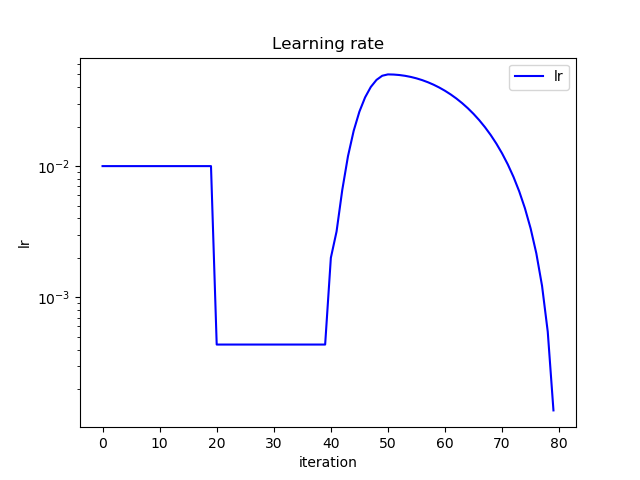

In [22]:
FitOneCycle(net, n_epoch=10, lr_max=0.05, opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

FindLR progress: 0.0%
FindLR progress: 20.0%
FindLR progress: 40.0%
FindLR progress: 60.0%
FindLR progress: 80.0%
FindLR progress: 100.0%


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
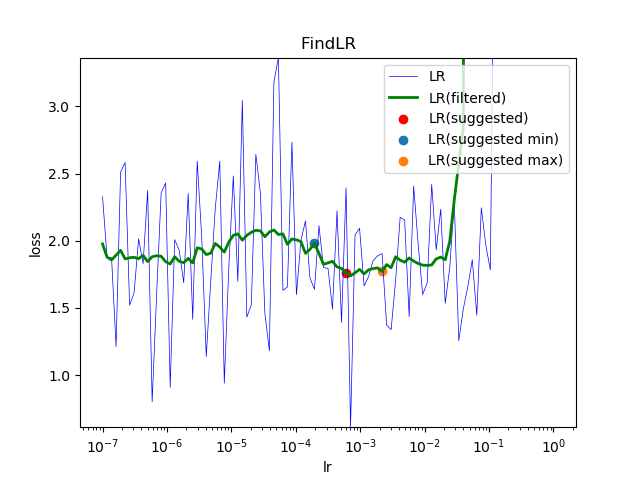

lr= 0.000602559586074358, lr_min=0.00019498445997580445, lr_max=0.0021877616239495525


In [23]:
lr,(lr_min,lr_max,_)= FindLR(net, opt=opt, f_loss=f_loss, dl_train=dl_train, tfm_batch=tfm_batch, device=device)
print(f'lr= {lr}, lr_min={lr_min}, lr_max={lr_max}')

i_epoch	loss(train)	loss(test)	metric(train)	metric(test)	 time
20	2.06801187	1.83761901	1.40120149	1.34622519	 0.139731
21	1.84536696	1.80717958	1.35455681	1.32955857	 0.101851
22	1.94374647	1.73685881	1.39318790	1.31169017	 0.115035
23	1.76642208	1.67520568	1.31940944	1.27687257	 0.119347
24	1.93514206	1.65297748	1.38809251	1.27864652	 0.105274
25	1.82809866	1.63935217	1.34696518	1.27433097	 0.097963
26	1.93273900	1.64653248	1.38929843	1.26626564	 0.108784
27	1.93790768	1.61213233	1.37957535	1.26661237	 0.113280
28	1.83835682	1.58858228	1.34222378	1.24210554	 0.110137
29	1.71138985	1.59000606	1.29639920	1.24656246	 0.126721
30	1.70487624	1.59519731	1.29914144	1.25923975	 0.169070
31	1.70278970	1.56113218	1.29633173	1.23260966	 0.082191
32	1.68752694	1.55697399	1.29847595	1.23924708	 0.111215
33	1.86896034	1.55110198	1.36567246	1.24300360	 0.116343
34	1.63702560	1.54591583	1.27756227	1.23903077	 0.109949
35	1.66073157	1.54348970	1.28643109	1.23906451	 0.091619
36	1.60921529	1.54186311

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
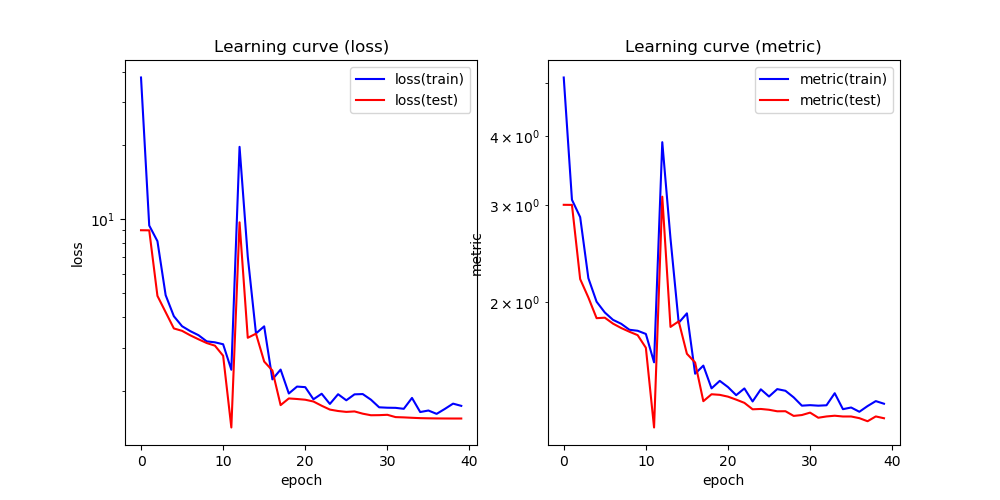

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
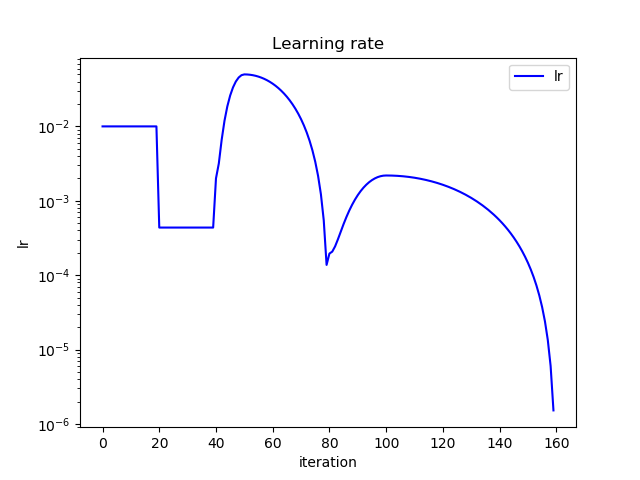

In [24]:
FitOneCycle(net, n_epoch=20, lr_max=lr_max, div_init=lr_max/lr_min, 
    opt=opt, f_loss=f_loss, f_metric=f_metric,
    dl_train=dl_train, dl_test=dl_test, tfm_batch=tfm_batch,
    callbacks=(logger.Callbacks(),disp.Callbacks()),
    device=device)
logger.Plot()
logger.PlotLR()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to  previous…
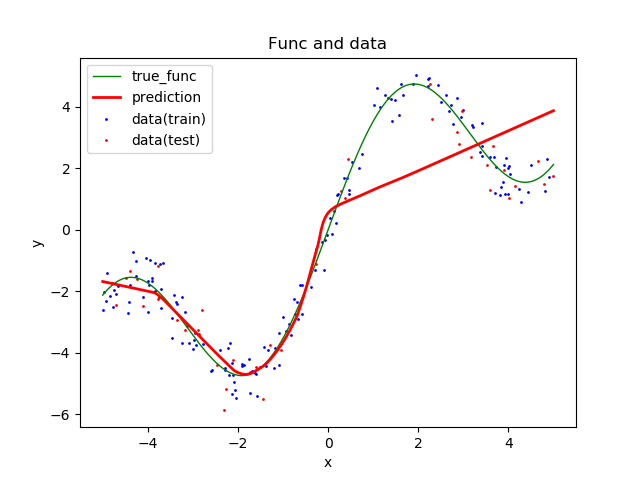

In [25]:
%matplotlib widget
fig= plt.figure()
ax_pred= fig.add_subplot(1,1,1,title='Func and data',xlabel='x',ylabel='y')
true_x= np.linspace(xmin,xmax,1000).reshape((-1,1))
pred_y= decode(Eval(net, torch.from_numpy(true_x).float(), device=device)).cpu()
ax_pred.plot(true_x, Func(true_x), color='green', linewidth=1, label='true_func')
ax_pred.scatter(data_x[idxes[:N_train]], data_y[idxes[:N_train]], s=1, color='blue', label='data(train)')
ax_pred.scatter(data_x[idxes[N_train:]], data_y[idxes[N_train:]], s=1, color='red', label='data(test)')
ax_pred.plot(true_x, pred_y, color='red', linewidth=2, label='prediction')
ax_pred.legend()